In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from my_multi_main4 import Net,test
from torchvision import datasets, transforms

In [2]:
model_file = 'mnist4_multi_97.7_0.0100_SGD_gfusedmax_0_1.00_1.00_2.pt'
params = model_file.strip('.pt').split('_')
_,_,acc,lr,optim_type,max_type,norm_flag,lam,gamma,head_cnt = \
    params[0],params[1],float(params[2]),float(params[3]),params[4],\
    params[5],bool(int(params[6])),float(params[7]),float(params[8]),int(params[9])
model = Net(max_type,norm_flag,lam,gamma,head_cnt)
model.load_state_dict(torch.load(model_file,map_location='cpu'))

In [3]:
model.eval()
use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', download=True, train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True, **kwargs)
#test_acc = test(None, model, device, test_loader)
#print(test_acc)

In [4]:
print(type(test_loader.dataset.test_data),test_loader.dataset.test_data.size())
test_data = test_loader.dataset.test_data

<class 'torch.Tensor'> torch.Size([10000, 28, 28])


In [11]:
import torch.nn as nn
import torch.nn.functional as F
def forward_att(att,x):
    N,C,H,W = x.size()
    x = x.reshape([N,H,W,C]) #[N,H,W,C]
    proj_x = att.proj_func(x) #[N,H,W,C']
    score_x = att.score_func(x) #[N,H,W,1]
    scores = torch.reshape(score_x,[N,-1,1])
    projs = torch.reshape(proj_x,[N,-1,att.output_size])
    weights = att.mapping_func(att.score_norm(scores),dim=-2)
    output = torch.sum(projs * weights,dim=-2)
    return proj_x,score_x,weights.reshape(score_x.size()),output
def forward(model,x):
    h1 = F.relu(model.conv1(x))
    h1_pooled = F.max_pool2d(h1, 2, 2)
    h2 = F.relu(model.conv2(h1_pooled))
    # h2_pooled = F.max_pool2d(h2, 2, 2)
    att_out = torch.cat([att(h2) for att in model.attention_pool],dim=1).view(-1,500)
    h3 = F.relu(att_out)
    h4 = model.fc2(h3)
    return h1,h1_pooled,h2,att_out,h3,h4
def weight_image(weight):
    image_size = 28
    recp_size = 8
    weight_size = 11
    stride = int((image_size-recp_size)/(weight_size-1))
    
    output = np.zeros([image_size,image_size])
    for i in range(weight_size):
        for j in range(weight_size):
            output[i*stride:(i*stride+recp_size),j*stride:(j*stride+recp_size)] += weight[i,j]
    return output
def weight_on_image(weight,image):
    output = np.zeros(weight.shape+(3,))
    output[:,:,0] = image
    output[:,:,2] = weight
    return output
norm_image = lambda x: (x.type(torch.float)/255.-0.1307)/0.3081

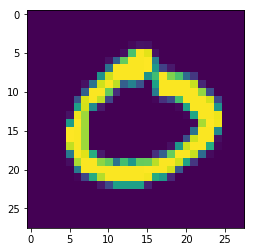

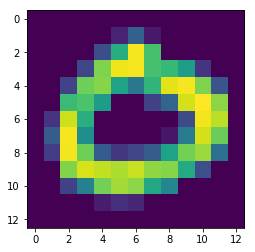

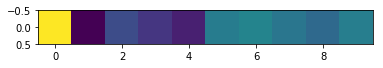

torch.Size([1, 11, 11, 250]) torch.Size([1, 11, 11, 1]) torch.Size([1, 11, 11, 1]) torch.Size([1, 250])


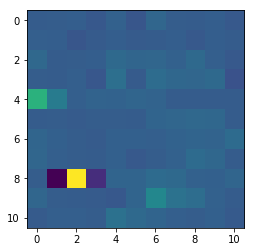

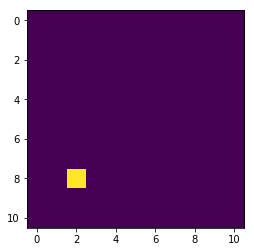

torch.Size([1, 11, 11, 250]) torch.Size([1, 11, 11, 1]) torch.Size([1, 11, 11, 1]) torch.Size([1, 250])


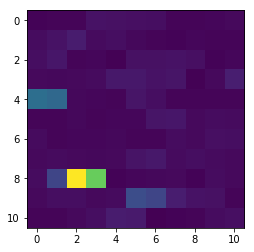

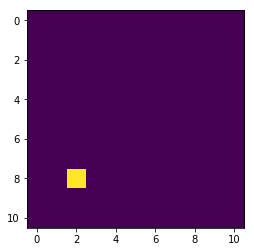

In [12]:
with torch.no_grad():
    index = np.random.choice(test_data.size()[0])
    plt.imshow(test_data[index])
    plt.show()
    h1,h1_pooled,h2,att_out,h3,h4 = forward(model,norm_image(test_data[index]).unsqueeze_(0).unsqueeze(0))
    plt.imshow(h1_pooled[0,10])
    plt.show()
    #plt.imshow(h2_pooled[0,10])
    #plt.show()
    plt.imshow(h4)
    plt.show()
    proj0,score0,weights0,att_out0 = forward_att(model.attention_pool[0],h2)
    print(proj0.shape,score0.shape,weights0.shape,att_out0.shape)
    plt.imshow(score0[0,:,:,0])
    plt.show()
    plt.imshow(weights0[0,:,:,0])
    plt.show()
    proj1,score1,weights1,att_out1 = forward_att(model.attention_pool[1],h2)
    print(proj1.shape,score1.shape,weights1.shape,att_out1.shape)
    plt.imshow(score1[0,:,:,0])
    plt.show()
    plt.imshow(weights1[0,:,:,0])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

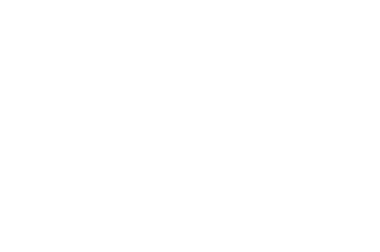

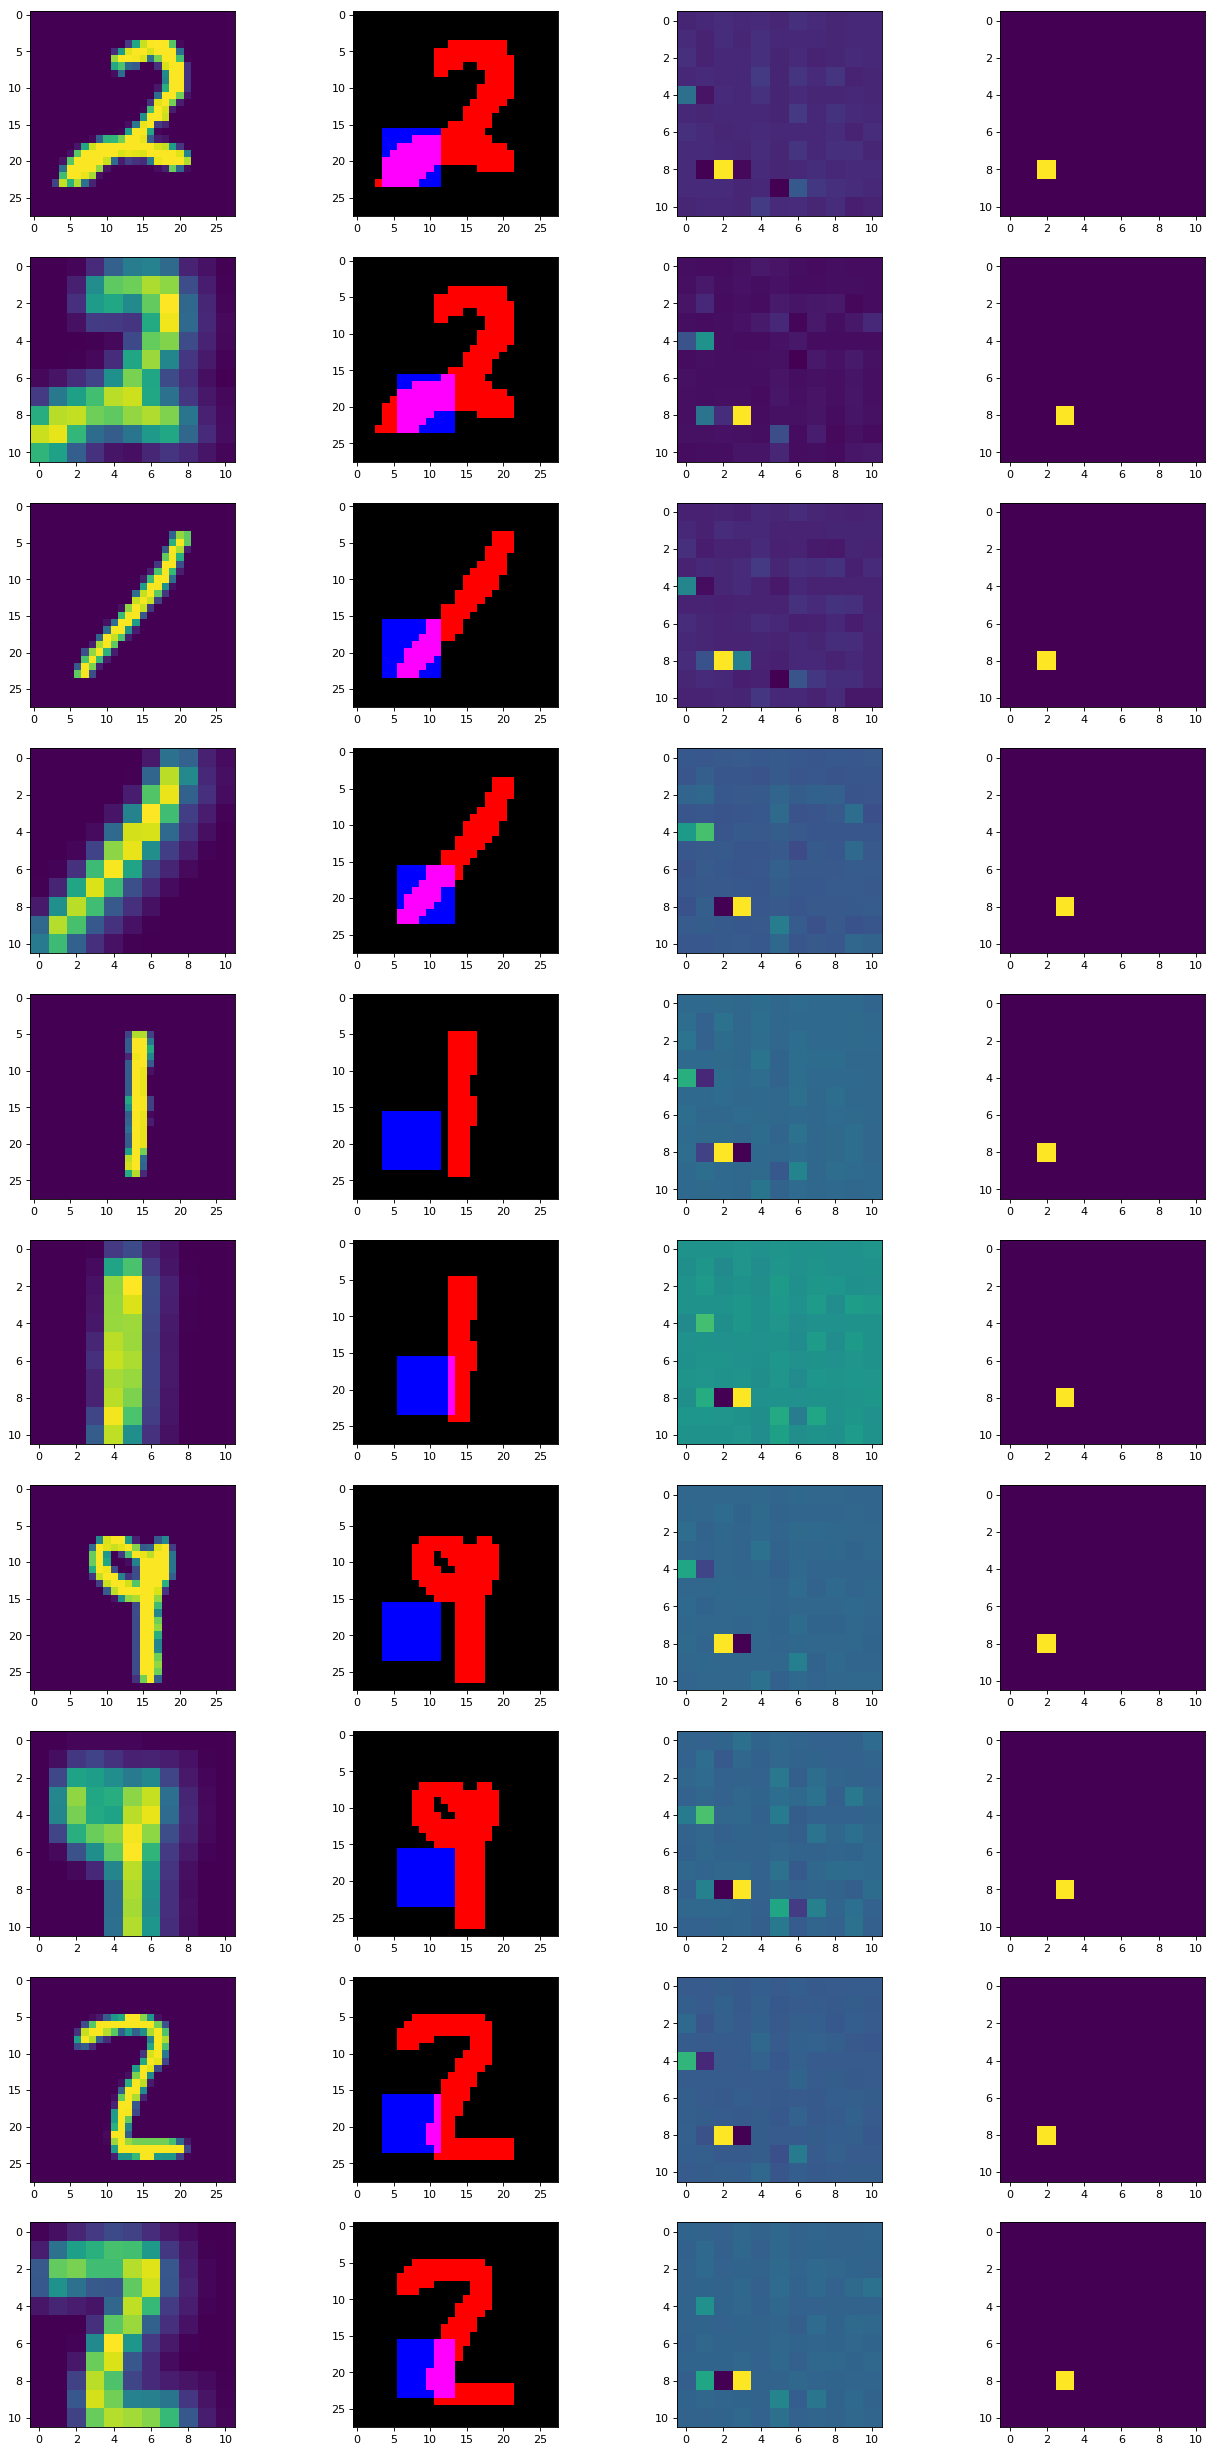

In [19]:
samples = 5
sample_per_row = 4
plt.axis('off')
fig=plt.figure(figsize=(20, 40), dpi= 80)
with torch.no_grad():
    for s in range(samples):
        index = np.random.choice(test_data.size()[0])
        h1,h1_pooled,h2,att_out,h3,h4 = forward(model,norm_image(test_data[index]).unsqueeze_(0).unsqueeze(0))
        proj0,score0,weights0,att_out0 = forward_att(model.attention_pool[0],h2)
        proj1,score1,weights1,att_out1 = forward_att(model.attention_pool[1],h2)
        image_weighted0 = weight_image(weights0[0,:,:,0].numpy()) 
        image_weighted1 = weight_image(weights1[0,:,:,0].numpy()) 
        image_with_weighted0 = weight_on_image(image_weighted0,test_data[index].numpy()) 
        image_with_weighted1 = weight_on_image(image_weighted1,test_data[index].numpy()) 
        
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+1)
        plt.imshow(test_data[index])
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+2)
        plt.imshow(image_with_weighted0)
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+3)
        plt.imshow(score0[0,:,:,0])
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+4)
        plt.imshow(weights0[0,:,:,0])
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+5)
        plt.imshow(torch.norm(h2,dim=1)[0])
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+6)
        plt.imshow(image_with_weighted1)
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+7)
        plt.imshow(score1[0,:,:,0])
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+8)
        plt.imshow(weights1[0,:,:,0])
plt.show()

In [21]:
h1,h1_pooled,h2,att_out,h3,h4 = forward(model,norm_image(test_data).unsqueeze_(1))
proj0,score0,weights0,att_out0 = forward_att(model.attention_pool[0],h2)
proj1,score1,weights1,att_out1 = forward_att(model.attention_pool[1],h2)

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20, 26, 26])
torch.Size([10000, 20, 13, 13])


In [22]:

all_weights0 = np.sum(np.abs(weights0[:,:,:,0].detach().numpy()),axis=0)
all_weights1 = np.sum(np.abs(weights1[:,:,:,0].detach().numpy()),axis=0)
print(all_weights0)
print(all_weights1)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [2.8486988e+01 3.1264154e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.00

9999.998


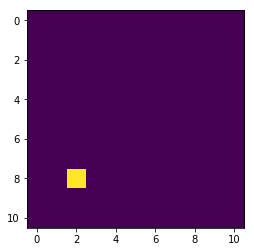

9999.998


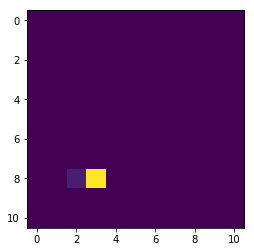

In [23]:
plt.imshow(all_weights0)
print(np.sum(all_weights0))
plt.show()
plt.imshow(all_weights1)
print(np.sum(all_weights1))
plt.show()

In [17]:
print(model.attention_pool[0].score_func.weight)
print(model.attention_pool[0].score_func.bias)
print(model.attention_pool[1].score_func.weight)
print(model.attention_pool[1].score_func.bias)

Parameter containing:
tensor([[ 0.0259,  0.0196,  0.1739,  0.3516,  0.1423,  0.1193,  0.0345,  0.0601,
         -0.0649, -0.1866, -0.0762, -0.0583,  0.0006,  0.1007,  0.1254,  0.0709,
          0.0838, -0.0288, -0.0225, -0.1167, -0.0998, -0.3004,  0.0921,  0.0255,
         -0.0574,  0.1923,  0.1228,  0.0990,  0.1585, -0.0825, -0.1961, -0.2049,
         -0.1997, -0.0413,  0.0010,  0.0600,  0.0742,  0.0347,  0.2910,  0.0530,
         -0.0098,  0.1114, -0.1778, -0.1760,  0.1524,  0.0663,  0.1419,  0.1114,
          0.3288,  0.3620]], requires_grad=True)
Parameter containing:
tensor([0.0944], requires_grad=True)
Parameter containing:
tensor([[ 1.4664e-01, -2.8211e-01, -3.4660e-01, -2.1407e-01, -2.3563e-01,
         -2.6445e-01,  5.2811e-02,  2.6337e-01,  2.4964e-01,  1.1613e-01,
          3.1548e-01,  1.1720e-01,  1.8196e-02,  1.3270e-01, -4.4715e-02,
          4.2360e-04,  6.1598e-02,  1.5462e-01,  4.0172e-01,  1.8132e-01,
          3.9537e-02,  4.6302e-01,  2.1578e-01,  3.1848e-02,  1.80

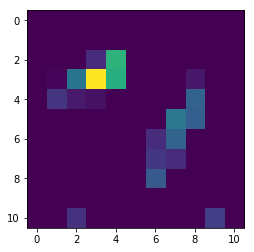

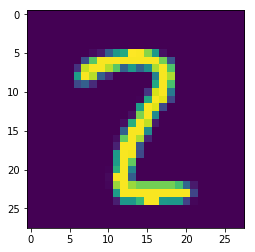

In [31]:
plt.imshow(h2[0,np.random.choice(50)])
plt.show()
plt.imshow(test_data[index])
plt.show()

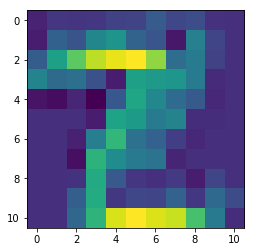

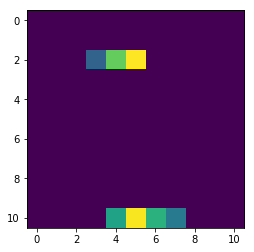

In [33]:
h2_trans = torch.transpose(h2,1,3)
scores_trans = model.attention_pool[0].score_func(h2_trans)
scores = torch.transpose(scores_trans,1,3)
plt.imshow(scores[0,0].detach().numpy())
plt.show()
scores_flat = scores.reshape(-1)
weights_flat = model.attention_pool[0].mapping_func(scores_flat,-1)
weights = weights_flat.reshape(scores.size())
plt.imshow(weights[0,0].detach().numpy())
plt.show()